In [1]:
import numpy as np
import pandas as pd
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten, Conv1D, Convolution1D, \
                         MaxPooling1D, GlobalAveragePooling1D, Reshape, CuDNNLSTM, CuDNNGRU, Concatenate, Input, LSTM, Layer
from keras.layers.wrappers import Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from bettertensorboard import TrainValTensorBoard
import os

Using TensorFlow backend.
/home/97212545/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/97212545/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/97212545/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/97212545/an

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1";  

In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Loading the data

In [4]:
data_dir = 'data/'
dataset_filename = 'structured-vs-nonstructured-1.csv'
rna_alphabet = 'A C G T'.split()
rna_size = 50

In [5]:
data = pd.read_csv(data_dir + dataset_filename, header=None)
data.head()

0  1
0  GAGAAGAGATCAGCCAACCATCAACCCGCCAATTGGCTGATCTTTT...  1
1  GAACATCCGAATCAAGCCTTCAGCCCCATGAAGGCTTGATTTCCCA...  1
2  GAATTTCAGCTTTGATCCCCCAGGATCAAAGCTGACCAGAATCCCA...  1
3  GAACCCCCCAGGAGAGCTCAATGAAATCACGCCCATTGAGCTTTCC...  1
4  GCAGATTCTGGATCACCCCGATCCAGAGCCTGCAAAAGAACCCATT...  1

In [6]:
X = np.array([list(i) for i in data[0].values])
X_all = np.array([list(i * rna_size) for i in rna_alphabet])

In [7]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(X_all)
X = one_hot_encoder.transform(X).reshape(-1, rna_size, len(rna_alphabet))
X.shape

(1000000, 50, 4)

In [8]:
y = data[1].values.reshape(-1, 1)
y.shape

(1000000, 1)

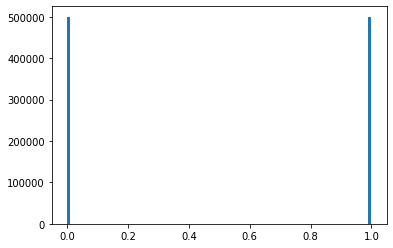

In [9]:
plt.hist(y, bins=100);

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [11]:
early_stopping = EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='auto')

In [12]:
def plot_history(history, metric):
    plt.figure(figsize=(16, 6));
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1);
    plt.plot(history.history[metric]);
    plt.plot(history.history['val_' + metric]);
    plt.title('Model ' + metric);
    plt.ylabel(metric);
    plt.xlabel('Epoch');
    plt.legend(['Train', 'Test'], loc='best');

    # Plot training & validation loss values
    plt.subplot(1, 2, 2);
    plt.plot(history.history['loss']);
    plt.plot(history.history['val_loss']);
    plt.title('Model loss');
    plt.ylabel('Loss');
    plt.xlabel('Epoch');
    plt.legend(['Train', 'Test'], loc='best');

# Training Models

In [12]:
tensorboard = TrainValTensorBoard()

## Fully Connected

In [17]:
def create_fc(input_shape):
    """
    a fully connected model which predicts from the sequence only
    """
    x = Input(shape=input_shape)

    flat = Flatten()(x)

    y = Dense(256)(flat)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)
    
    y = Dense(256)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)
    
    y = Dense(256)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)
    
    y = Dense(256)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('sigmoid')(y)

    return Model(inputs=x, outputs=y)

In [18]:
fc = create_fc(X_train.shape[1:])
fc.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
fc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 4)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               51456     
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               65792     
__________

In [ ]:
fc_history = fc.fit(X_train, y_train, batch_size=256, epochs=150, validation_split=.2)

Train on 640000 samples, validate on 160000 samples
Epoch 1/150
640000/640000 [==============================] - 36s 55us/step - loss: 0.6719 - acc: 0.5958 - val_loss: 0.6534 - val_acc: 0.6147
Epoch 2/150
640000/640000 [==============================] - 32s 50us/step - loss: 0.6549 - acc: 0.6143 - val_loss: 0.6449 - val_acc: 0.6271
Epoch 3/150
640000/640000 [==============================] - 31s 49us/step - loss: 0.6487 - acc: 0.6225 - val_loss: 0.6383 - val_acc: 0.6347
Epoch 4/150
640000/640000 [==============================] - 30s 47us/step - loss: 0.6439 - acc: 0.6285 - val_loss: 0.6349 - val_acc: 0.6391
Epoch 5/150
640000/640000 [==============================] - 30s 47us/step - loss: 0.6400 - acc: 0.6324 - val_loss: 0.6312 - val_acc: 0.6434
Epoch 6/150
640000/640000 [==============================] - 30s 47us/step - loss: 0.6370 - acc: 0.6367 - val_loss: 0.6285 - val_acc: 0.6463
Epoch 7/150
640000/640000 [==============================] - 30s 47us/step - loss: 0.6343 - acc: 0.639

In [ ]:
plot_history(fc_history, 'acc')
plt.show();

## CNN

In [16]:
def create_cnn(input_shape):
    """
    a CNN model which predicts from the sequence only
    """
    x = Input(shape=input_shape)

    cnn = Conv1D(filters=64, kernel_size=5)(x)
    cnn = BatchNormalization()(cnn)
    cnn = Activation('relu')(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)

    cnn = Conv1D(filters=64, kernel_size=5)(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Activation('relu')(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)

    cnn = Conv1D(filters=64, kernel_size=5)(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Activation('relu')(cnn)
    cnn = MaxPooling1D(pool_size=4)(cnn)

    flat = Flatten()(cnn)

    y = Dense(64)(flat)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(32)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('sigmoid')(y)

    return Model(inputs=x, outputs=y)

In [19]:
cnn = create_cnn(X_train.shape[1:])
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.summary()
# plot_model(cnn, show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50, 4)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 46, 64)            1344      
_________________________________________________________________
batch_normalization_13 (Batc (None, 46, 64)            256       
_________________________________________________________________
activation_13 (Activation)   (None, 46, 64)            0         
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 19, 64)            20544     
_________________________________________________________________
batch_normalization_14 (Batc (None, 19, 64)            256       
__________

In [20]:
cnn_history = cnn.fit(X_train, y_train, batch_size=256, epochs=50, validation_split=.2)

Train on 640000 samples, validate on 160000 samples
Epoch 1/50
640000/640000 [==============================] - 54s 85us/step - loss: 0.6434 - acc: 0.6364 - val_loss: 0.6315 - val_acc: 0.6427
Epoch 2/50
640000/640000 [==============================] - 45s 71us/step - loss: 0.6096 - acc: 0.6722 - val_loss: 0.5978 - val_acc: 0.6780
Epoch 3/50
640000/640000 [==============================] - 45s 70us/step - loss: 0.5944 - acc: 0.6862 - val_loss: 0.5856 - val_acc: 0.6894
Epoch 4/50
640000/640000 [==============================] - 45s 70us/step - loss: 0.5821 - acc: 0.6973 - val_loss: 0.5710 - val_acc: 0.7009
Epoch 5/50
640000/640000 [==============================] - 45s 70us/step - loss: 0.5671 - acc: 0.7094 - val_loss: 0.5585 - val_acc: 0.7100
Epoch 6/50
640000/640000 [==============================] - 44s 68us/step - loss: 0.5552 - acc: 0.7194 - val_loss: 0.5592 - val_acc: 0.7078
Epoch 7/50
640000/640000 [==============================] - 44s 69us/step - loss: 0.5470 - acc: 0.7262 - val

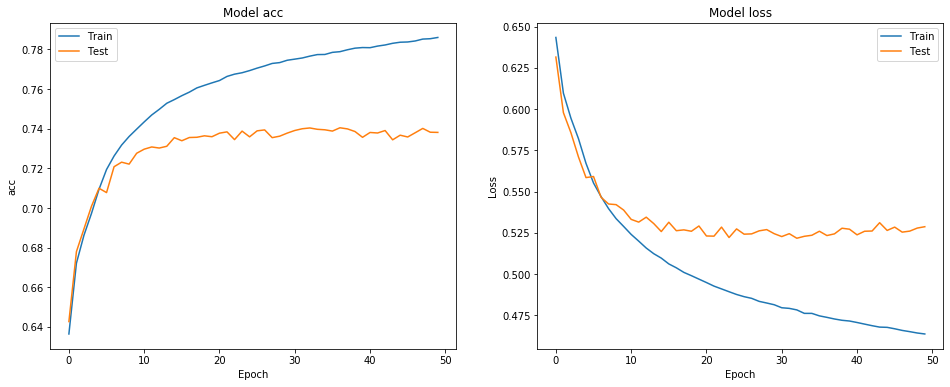

In [21]:
plot_history(cnn_history, 'acc')
plt.show();

In [17]:
def create_cnn_codon(input_shape):
    """
    a CNN model with a single convolution layer of size 3, which predicts from the sequence only
    """
    x = Input(shape=input_shape)

    cnn = Conv1D(filters=64, kernel_size=3)(x)
    cnn = BatchNormalization()(cnn)
    cnn = Activation('relu')(cnn)

    flat = Flatten()(cnn)

    y = Dense(64)(flat)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(32)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('sigmoid')(y)

    return Model(inputs=x, outputs=y)

In [18]:
cnn_codon = create_cnn_codon(X_train.shape[1:])
cnn_codon.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_codon.summary()
# plot_model(cnn, show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 4)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 48, 64)            832       
_________________________________________________________________
batch_normalization_5 (Batch (None, 48, 64)            256       
_________________________________________________________________
activation_5 (Activation)    (None, 48, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                196672    
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
__________

In [19]:
cnn_codon_history = cnn_codon.fit(X_train, y_train, batch_size=256, epochs=50, validation_split=.2)

Train on 640000 samples, validate on 160000 samples
Epoch 1/50
640000/640000 [==============================] - 46s 72us/step - loss: 0.6552 - acc: 0.6201 - val_loss: 0.6303 - val_acc: 0.6449
Epoch 2/50
640000/640000 [==============================] - 41s 64us/step - loss: 0.6349 - acc: 0.6429 - val_loss: 0.6218 - val_acc: 0.6554
Epoch 3/50
640000/640000 [==============================] - 41s 64us/step - loss: 0.6287 - acc: 0.6502 - val_loss: 0.6180 - val_acc: 0.6597
Epoch 4/50
640000/640000 [==============================] - 41s 64us/step - loss: 0.6243 - acc: 0.6556 - val_loss: 0.6128 - val_acc: 0.6650
Epoch 5/50
640000/640000 [==============================] - 41s 64us/step - loss: 0.6203 - acc: 0.6601 - val_loss: 0.6087 - val_acc: 0.6692
Epoch 6/50
640000/640000 [==============================] - 40s 63us/step - loss: 0.6157 - acc: 0.6655 - val_loss: 0.6048 - val_acc: 0.6719
Epoch 7/50
640000/640000 [==============================] - 41s 63us/step - loss: 0.6083 - acc: 0.6737 - val

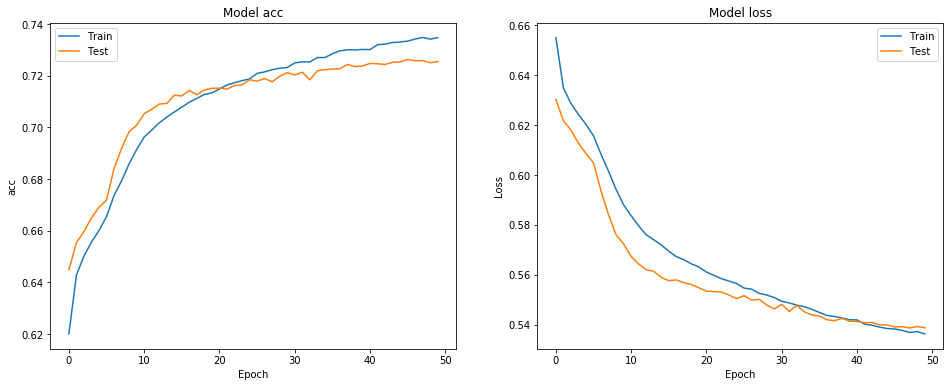

In [20]:
plot_history(cnn_codon_history, 'acc')
plt.show();

## RNN

In [ ]:
def create_rnn(input_shape):
    """
    a Bidirectional LSTM model which predicts from the sequence only
    """
    x = Input(shape=input_shape)

    rnn = Bidirectional(CuDNNLSTM(units=32, return_sequences=True))(x)

    rnn = Bidirectional(CuDNNLSTM(units=32, return_sequences=True))(rnn)

    flat = Flatten()(rnn)

    y = Dense(32)(flat)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(32)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('linear')(y)

    return Model(inputs=x, outputs=y)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 50, 4)             0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 50, 64)            9728      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 50, 64)            25088     
_________________________________________________________________
flatten_6 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                102432    
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
activation_16 (Activation)   (None, 32)                0   

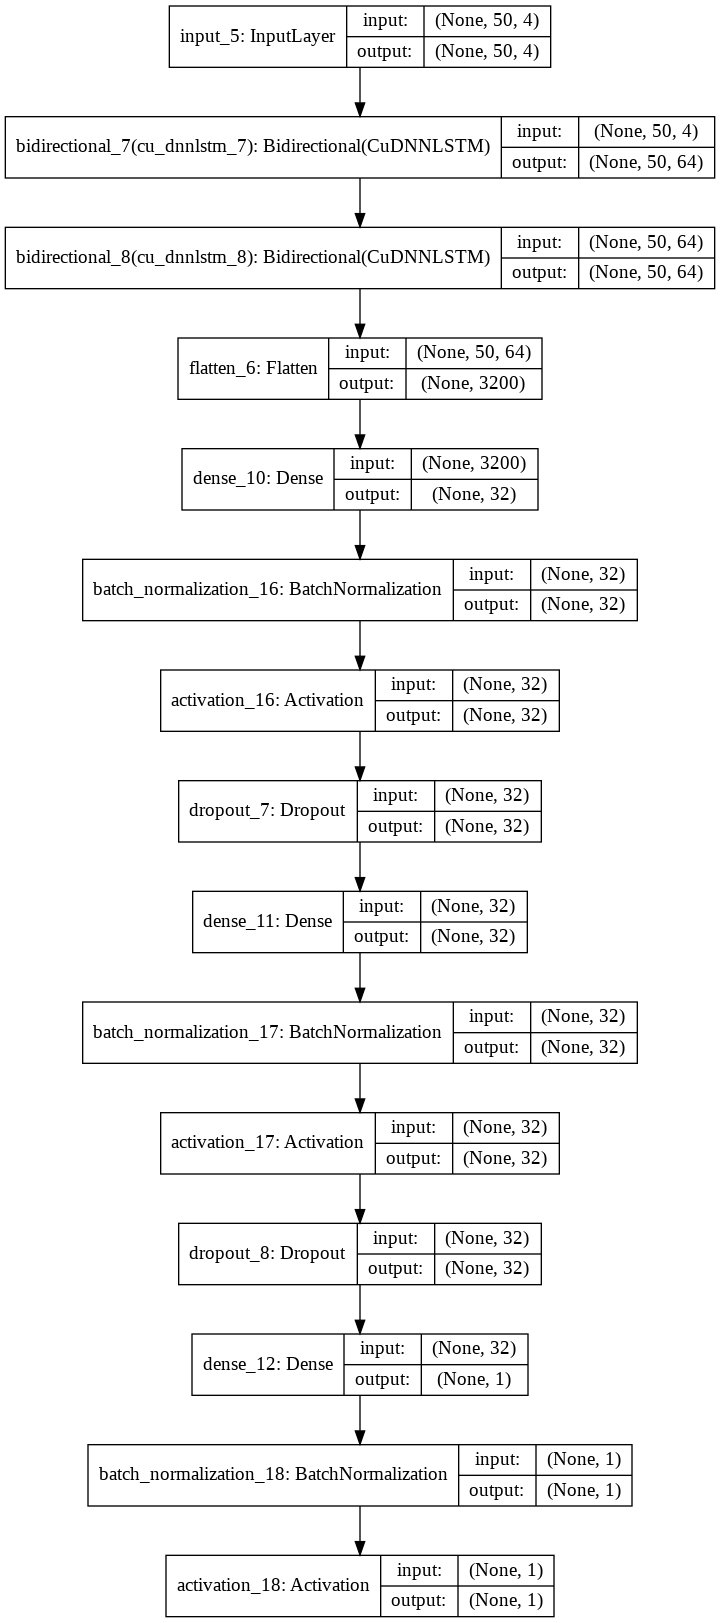

In [ ]:
rnn = create_rnn(X_train.shape[1:])
rnn.compile(optimizer='rmsprop', loss=rmse, metrics=[r_square])
rnn.summary()
plot_model(rnn, show_shapes=True)

In [ ]:
rnn_history = rnn.fit(X_train, y_train, batch_size=512, epochs=30, validation_split=.2)

Train on 640000 samples, validate on 160000 samples
Epoch 1/20
640000/640000 [==============================] - 160s 250us/step - loss: 4.9886 - r_square: -4.6508 - val_loss: 3.6038 - val_r_square: -1.8768
Epoch 2/20
640000/640000 [==============================] - 157s 246us/step - loss: 2.9283 - r_square: -0.9635 - val_loss: 2.1240 - val_r_square: 0.0044
Epoch 3/20
640000/640000 [==============================] - 157s 245us/step - loss: 2.0484 - r_square: 0.0678 - val_loss: 2.0175 - val_r_square: 0.1017
Epoch 4/20
640000/640000 [==============================] - 157s 246us/step - loss: 2.0134 - r_square: 0.0999 - val_loss: 2.0124 - val_r_square: 0.1053
Epoch 5/20
640000/640000 [==============================] - 157s 245us/step - loss: 1.9877 - r_square: 0.1224 - val_loss: 1.9689 - val_r_square: 0.1437
Epoch 6/20
640000/640000 [==============================] - 157s 245us/step - loss: 1.9687 - r_square: 0.1392 - val_loss: 1.9847 - val_r_square: 0.1304
Epoch 7/20
640000/640000 [=======

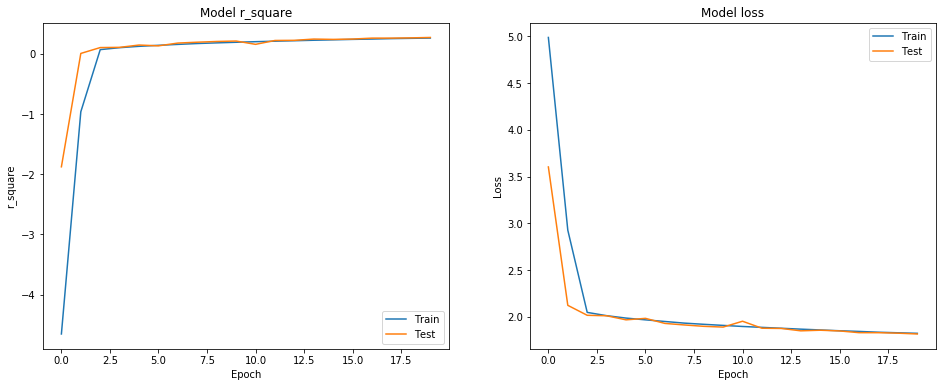

In [ ]:
plot_history(rnn_history, 'r_square')
plt.show();

It will go up to 0.36 of $R^2$.

## Fixed Dilated CNN

In [13]:
class FixedDilatedCNN(Layer):
    """
    This layer takes a tensor in shape (n_samples, rna_length, 4) and returns a
    tensor in shape (n_samples, rna_length, n_structural_features)

    It uses a kind of dilated CNN with no trainable parameters to extract the
    RNA structural features
    """

    def __init__(self, dilation_start=2, dilation_end=None, n_bulge=2, **kwargs):
        self.dilation_start = dilation_start
        self.dilation_end = dilation_end
        self.n_bulge = n_bulge
        self.n_dilations = None
        super(FixedDilatedCNN, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dilation_end is None:
            self.dilation_end = int(input_shape[1] / 2 - 1)
        self.n_dilations = self.dilation_end - self.dilation_start
        super(FixedDilatedCNN, self).build(input_shape)

    def call(self, x):
        result = []

        for s in range(self.dilation_start, self.dilation_end):
            x_padded_left = K.temporal_padding(x, (s+1, 0))
            x_padded_right = K.temporal_padding(x, (0, s+1))
            dilation = x_padded_right[:, s+1:, :] * x_padded_left[:, :-(s+1), ::-1]
            dilation = dilation * np.array([[2, 3, 3, 2]]).reshape((1, 1, 4))
            dilation = K.sum(dilation, axis=2)
            result.append(dilation)

            for d in range(1, self.n_bulge+1):
                # left bulges
                x_padded_left = K.temporal_padding(x, (s+1+d, 0))
                x_padded_right = K.temporal_padding(x, (0, s+1))
                dilation = x_padded_right[:, s+1:, :] * x_padded_left[:, :-(s+1+d), ::-1]
                dilation = dilation * np.array([[2, 3, 3, 2]]).reshape((1, 1, 4))
                dilation = K.sum(dilation, axis=2)
                result.append(dilation)
            for d in range(1, self.n_bulge+1):
                # right bulges
                x_padded_left = K.temporal_padding(x, (s+1, 0))
                x_padded_right = K.temporal_padding(x, (0, s+1+d))
                dilation = x_padded_right[:, s+1+d:, :] * x_padded_left[:, :-(s+1), ::-1]
                dilation = dilation * np.array([[2, 3, 3, 2]]).reshape((1, 1, 4))
                dilation = K.sum(dilation, axis=2)
                result.append(dilation)
 
        result = K.stack(result)
        result = K.permute_dimensions(result, (1, 2, 0))
#         result = K.permute_dimensions(result, (1, 2, 0, 3))
#         result = K.reshape(result, (-1, result.shape[1], result.shape[2] * result.shape[3]))
        return result

    def compute_output_shape(self, input_shape):
#         return (input_shape[0], input_shape[1], self.n_dilations * (self.n_bulge * 2 + 1) * 4)
        return (input_shape[0], input_shape[1], self.n_dilations * (self.n_bulge * 2 + 1))

In [19]:
class FixedDilatedCNN(Layer):
    """
    This layer takes a tensor in shape (n_samples, rna_length, 4) and returns a
    tensor in shape (n_samples, rna_length, n_structural_features)

    It uses a kind of dilated CNN with no trainable parameters to extract the
    RNA structural features
    """

    def __init__(self, dilation_start=2, dilation_end=None, n_bulge=2, **kwargs):
        self.dilation_start = dilation_start
        self.dilation_end = dilation_end
        self.n_bulge = n_bulge
        self.n_dilations = None
        super(FixedDilatedCNN, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dilation_end is None:
            self.dilation_end = int(input_shape[1] / 2 - 1)
        self.n_dilations = self.dilation_end - self.dilation_start
        super(FixedDilatedCNN, self).build(input_shape)

    def dilate(self, x, space, weights):
        weights = np.array(weights).reshape((1, 1, -1))
        x_padded_left = K.temporal_padding(x, (space+1, 0))
        x_padded_right = K.temporal_padding(x, (0, space+1))
        dilation = x_padded_right[:, space+1:, :] * x_padded_left[:, :-(space+1), ::-1]
        dilation = dilation * weights
        return K.sum(dilation, axis=2)
    
    def left_bulge_dilate(self, x, space, weights, bulge_size):
        x_padded_left = K.temporal_padding(x, (space+1+bulge_size, 0))
        x_padded_right = K.temporal_padding(x, (0, space+1))
        dilation = x_padded_right[:, space+1:, :] * x_padded_left[:, :-(space+1+bulge_size), ::-1]
        weights = np.array(weights).reshape((1, 1, -1))
        dilation = dilation * weights
        return K.sum(dilation, axis=2)
    
    def right_bulge_dilate(self, x, space, weights, bulge_size):
        x_padded_left = K.temporal_padding(x, (space+1, 0))
        x_padded_right = K.temporal_padding(x, (0, space+1+bulge_size))
        dilation = x_padded_right[:, space+1+bulge_size:, :] * x_padded_left[:, :-(space+1), ::-1]
        weights = np.array(weights).reshape((1, 1, -1))
        dilation = dilation * weights
        return K.sum(dilation, axis=2)
        
        
    def call(self, x):
        result = []

        for s in range(self.dilation_start, self.dilation_end):
            AU_CG = self.dilate(x, s, weights=[2, 3, 3, 2])
            GU = self.dilate(x[:, :, 2:], s, weights=[2, 2])
            result.append(AU_CG + GU)

            for d in range(1, self.n_bulge+1):
                # left bulges
                dilation = self.left_bulge_dilate(x, s, [2, 3, 3, 2], d)
                result.append(dilation)
                
            for d in range(1, self.n_bulge+1):
                # right bulges
                dilation = self.right_bulge_dilate(x, s, [2, 3, 3, 2], d)
                result.append(dilation)
 
        result = K.stack(result)
        result = K.permute_dimensions(result, (1, 2, 0))
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.n_dilations * (self.n_bulge * 2 + 1))

## Fixed Dilated CNN + CNN

In [20]:
def create_fixed_dilated_cnn(input_shape):
    x = Input(shape=input_shape)
    x_dilated = FixedDilatedCNN(dilation_start=2)(x)

    cnn1 = Conv1D(filters=64, kernel_size=16, padding='same')(x)
    cnn1 = BatchNormalization()(cnn1)
    cnn1 = Activation('relu')(cnn1)
    cnn1 = MaxPooling1D(pool_size=2)(cnn1)

    cnn1 = Conv1D(filters=64, kernel_size=10, padding='same')(cnn1)
    cnn1 = BatchNormalization()(cnn1)
    cnn1 = Activation('relu')(cnn1)
    cnn1 = MaxPooling1D(pool_size=2)(cnn1)

    cnn1 = Conv1D(filters=64, kernel_size=5)(cnn1)
    cnn1 = BatchNormalization()(cnn1)
    cnn1 = Activation('relu')(cnn1)
    cnn1 = MaxPooling1D(pool_size=4)(cnn1)

    cnn2 = Conv1D(filters=64, kernel_size=12)(x_dilated)
    cnn2 = BatchNormalization()(cnn2)
    cnn2 = Activation('relu')(cnn2)
    cnn2 = MaxPooling1D(pool_size=2)(cnn2)

    cnn2 = Conv1D(filters=64, kernel_size=7)(cnn2)
    cnn2 = BatchNormalization()(cnn2)
    cnn2 = Activation('relu')(cnn2)
    cnn2 = MaxPooling1D(pool_size=2)(cnn2)

    cnn2 = Conv1D(filters=64, kernel_size=5)(cnn2)
    cnn2 = BatchNormalization()(cnn2)
    cnn2 = Activation('relu')(cnn2)
    cnn2 = MaxPooling1D(pool_size=2)(cnn2)

    flat = Concatenate()([Flatten()(cnn1), Flatten()(cnn2)])

    y = Dense(64)(flat)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(32)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('sigmoid')(y)

    return Model(inputs=x, outputs=y)

In [21]:
fixed_dilated_cnn = create_fixed_dilated_cnn(X_train.shape[1:])
fixed_dilated_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
fixed_dilated_cnn.summary()
# plot_model(fixed_dilated_cnn, show_shapes=True)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50, 4)        0                                            
__________________________________________________________________________________________________
fixed_dilated_cnn_3 (FixedDilat (None, 50, 110)      0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 64)       4160        input_3[0][0]                    
________________________________________________________________________________________________

In [ ]:
fdcnn_history = fixed_dilated_cnn.fit(X_train, y_train, batch_size=256, epochs=50, validation_split=.2)

Train on 640000 samples, validate on 160000 samples
Epoch 1/50
640000/640000 [==============================] - 109s 171us/step - loss: 0.5726 - acc: 0.7018 - val_loss: 0.4449 - val_acc: 0.7915
Epoch 2/50
640000/640000 [==============================] - 92s 143us/step - loss: 0.3760 - acc: 0.8395 - val_loss: 0.3137 - val_acc: 0.8647
Epoch 3/50
640000/640000 [==============================] - 91s 142us/step - loss: 0.2817 - acc: 0.8866 - val_loss: 0.2594 - val_acc: 0.8913
Epoch 4/50
640000/640000 [==============================] - 91s 142us/step - loss: 0.2371 - acc: 0.9068 - val_loss: 0.2338 - val_acc: 0.9028
Epoch 5/50
640000/640000 [==============================] - 91s 142us/step - loss: 0.2076 - acc: 0.9197 - val_loss: 0.2197 - val_acc: 0.9103
Epoch 6/50
640000/640000 [==============================] - 90s 140us/step - loss: 0.1856 - acc: 0.9287 - val_loss: 0.2087 - val_acc: 0.9161
Epoch 7/50
640000/640000 [==============================] - 91s 142us/step - loss: 0.1697 - acc: 0.93

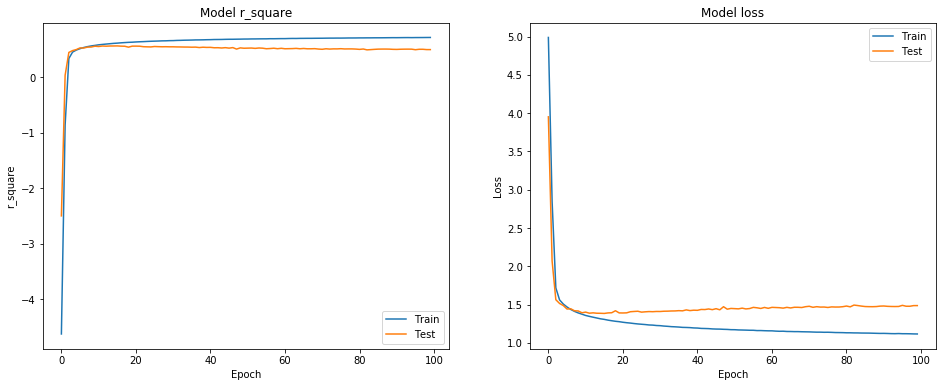

In [22]:
plot_history(fdcnn_history, 'acc')
plt.show();

## Fixed Dilated CNN + RNN

In [14]:
def create_fixed_dilated_cnn_rnn(input_shape):
    x = Input(shape=input_shape)
    x_dilated = FixedDilatedCNN(dilation_start=2)(x)

    rnn1 = Bidirectional(CuDNNLSTM(units=32, return_sequences=True))(x)

    rnn1 = Bidirectional(CuDNNLSTM(units=16, return_sequences=True))(rnn1)
    
    rnn2 = Bidirectional(CuDNNLSTM(units=32, return_sequences=True))(x_dilated)
    
    rnn2 = Bidirectional(CuDNNLSTM(units=16, return_sequences=True))(rnn2)

    flat = Concatenate()([Flatten()(rnn1), Flatten()(rnn2)])

    y = Dense(32)(flat)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(32)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('sigmoid')(y)

    return Model(inputs=x, outputs=y)

In [17]:
fixed_dilated_cnn_rnn = create_fixed_dilated_cnn_rnn(X_train.shape[1:])
fixed_dilated_cnn_rnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
fixed_dilated_cnn_rnn.summary()
# plot_model(fixed_dilated_cnn, show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50, 4)        0                                            
__________________________________________________________________________________________________
fixed_dilated_cnn_2 (FixedDilat (None, 50, 110)      0           input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 50, 64)       9728        input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 50, 64)       36864       fixed_dilated_cnn_2[0][0]        
__________________________________________________________________________________________________
bidirectio

In [18]:
fdcnn_rnn_history = fixed_dilated_cnn_rnn.fit(X_train, y_train, batch_size=256, epochs=50, validation_split=.2,
                                             callbacks=[tensorboard])

Train on 640000 samples, validate on 160000 samples
Epoch 1/50
640000/640000 [==============================] - 112s 176us/step - loss: 0.5252 - acc: 0.7371 - val_loss: 0.3765 - val_acc: 0.8355
Epoch 2/50
640000/640000 [==============================] - 106s 165us/step - loss: 0.3110 - acc: 0.8732 - val_loss: 0.2581 - val_acc: 0.8948
Epoch 3/50
640000/640000 [==============================] - 104s 162us/step - loss: 0.2516 - acc: 0.9013 - val_loss: 0.2506 - val_acc: 0.9021
Epoch 4/50
640000/640000 [==============================] - 104s 162us/step - loss: 0.2217 - acc: 0.9141 - val_loss: 0.2208 - val_acc: 0.9106
Epoch 5/50
640000/640000 [==============================] - 107s 166us/step - loss: 0.2022 - acc: 0.9227 - val_loss: 0.1935 - val_acc: 0.9225
Epoch 6/50
640000/640000 [==============================] - 105s 164us/step - loss: 0.1883 - acc: 0.9289 - val_loss: 0.1992 - val_acc: 0.9214
Epoch 7/50
640000/640000 [==============================] - 103s 162us/step - loss: 0.1774 - acc

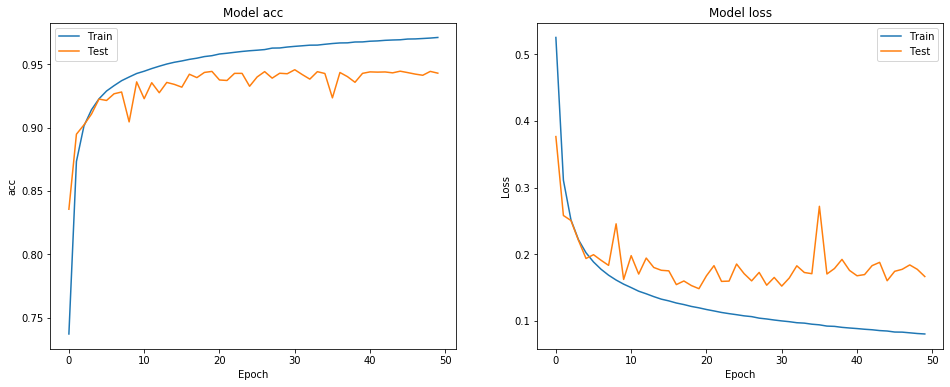

In [19]:
plot_history(fdcnn_rnn_history, 'acc')
plt.show();